In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import xml.etree.ElementTree as ET
import numpy as np
import plaidml.keras
import PIL.Image as Image
plaidml.keras.install_backend()

In [150]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh,probs):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    #if boxes.dtype.kind == "i":
        #boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the scores
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    
    final_boxes = []
    while len(idxs) > 0:
        #print('hi')
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))

        # return only the bounding boxes that were picked using the
        # integer data type
        #eturn boxes[pick].astype("int")
        final_boxes.append(boxes[pick])
        #print(boxes[pick])
    return boxes[pick]

In [144]:
from keras.models import Sequential,load_model

In [171]:
def rcnn(image,base_model_name):
    model = load_model(base_model_name)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    results = ss.process()
    copy = image.copy()
    copy2 = image.copy()
    positive_boxes = []
    probs = []
    
    for box in results:
        x1 = box[0]
        y1 = box[1]
        x2 = box[0]+box[2]
        y2 = box[1]+box[3]
        
        roi = image.copy()[y1:y2,x1:x2]
        roi = cv2.resize(roi,(128,128))
        roi_use = roi.reshape((1,128,128,3))
        class_pred = model.predict_classes(roi_use)[0][0]
        
        if class_pred == 1:
            prob = model.predict(roi_use)[0][0]
            if prob > 0.98:
                positive_boxes.append([x1,y1,x2,y2])
                probs.append(prob)
                cv2.rectangle(copy2,(x1,y1),(x2,y2),(255,0,0),5)
                
    cleaned_boxes = non_max_suppression_fast(np.array(positive_boxes),0.1,probs)
    total_boxes = 0
    for clean_box in cleaned_boxes:
        clean_x1 = clean_box[0]
        clean_y1 = clean_box[1]
        clean_x2 = clean_box[2]
        clean_y2 = clean_box[3]
        total_boxes+=1
        cv2.rectangle(copy,(clean_x1,clean_y1),(clean_x2,clean_y2),(0,255,0),3)
    #plt.imshow(copy2)
    plt.imshow(copy)

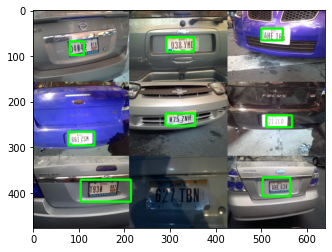

In [172]:
test_img = cv2.imread('many_plates.jpg')
rcnn(image=test_img,base_model_name='base_model.h5')